# SpaceX Falcon 9 first stage Landing Prediction

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/Falcon9_rocket_family.svg)

In this capstone, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. The following is an example of a successful and launch.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif)

Several examples of an unsuccessful landing are shown here:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/crash.gif)

Most unsuccessful landings are planned. Space X performs a controlled landing in the oceans.

## Import Libraries and Define Auxiliary Functions

In [101]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
from math import sin, cos, sqrt, atan2, radians
# Datetime is a library that allows us to represent dates
import datetime

# DataViz
import seaborn as sns
import matplotlib.pyplot as plt

# Folium Mapping
!pip install folium
import folium
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

# Web Screping
import sys
!pip3 install beautifulsoup4
from bs4 import BeautifulSoup
import re
import unicodedata

# IBM DB2
!pip install sqlalchemy --user
!pip install ibm_db --user
!pip install ipython-sql --user
!pip install ibm_db_sa --user
import ibm_db

## Preprocessing and Modeling ##
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
# Import Classification Report to compare other metrics
from sklearn.metrics import classification_report

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the `rocket` column we would like to learn the booster name.

In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the `launchpad` we would like to know the name of the launch site being used, the logitude, and the latitude.

In [3]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the `payload` we would like to learn the mass of the payload and the orbit that it is going to.

In [4]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From `cores` we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [5]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let's start requesting rocket launch data from SpaceX API with the following URL:

In [6]:
# Request URL
spacex_url="https://api.spacexdata.com/v4/launches/past"

# Response
response = requests.get(spacex_url)

Check the content of the response:

In [7]:
# Check content
#print(response.content)

To make the requested JSON results more consistent, we will use the following static response object for this project:

In [8]:
# Static Request URL
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

# Response
response = requests.get(spacex_url)

We should see that the request was successfull with the 200 status response code:

In [9]:
# Response Status
response.status_code

200

Now we decode the response content as a Json using `.json()` and turn it into a Pandas dataframe using `.json_normalize()`.

In [10]:
# Decode Json
response_json = response.json()

# Convert into a Pandas DataFrame
data = pd.json_normalize(response_json)

Using the dataframe `data` print the first 5 rows:

In [11]:
# Show first 5 rows
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/6c/cb/na1tzhHs_o.png,https://images2.imgbox.com/4a/80/k1oAkY0k_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

Some columns are not necessary so we will select a subset from our DataFrame with only the columns we want and we will also do some cleaning and data extractions.

In [12]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

You will notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns `rocket`, `payloads`, `launchpad`, and `cores`.

For that, we need to create empty lists to store the API responses for the columns mentioned above.

**Observation**: These variables have already been mentioned while importing the functions earlier, so we must create the variables with the same names.

In [13]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

Now we can use the previously imported functions to assign each response to its respective variable:

In [14]:
# Call getBoosterVersion
getBoosterVersion(data)

# Call getLaunchSite
getLaunchSite(data)

# Call getPayloadData
getPayloadData(data)

# Call getCoreData
getCoreData(data)

Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.

In [15]:
# Dictionary of obtained data
launch_dict = {'FlightNumber': list(data['flight_number']),
               'Date': list(data['date']),
               'BoosterVersion':BoosterVersion,
               'PayloadMass':PayloadMass,
               'Orbit':Orbit,
               'LaunchSite':LaunchSite,
               'Outcome':Outcome,
               'Flights':Flights,
               'GridFins':GridFins,
               'Reused':Reused,
               'Legs':Legs,
               'LandingPad':LandingPad,
               'Block':Block,
               'ReusedCount':ReusedCount,
               'Serial':Serial,
               'Longitude': Longitude,
               'Latitude': Latitude}

# Get a Pandas DataFrame from the dictionary
launch_data = pd.DataFrame(launch_dict)

In [16]:
# Show first 5 rows
launch_data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the BoosterVersion column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called data_falcon9.

In [17]:
# Selecting only Falcon 9 launches
data_falcon9 = launch_data[launch_data['BoosterVersion'] != 'Falcon 1']

In [18]:
# Check if we have only Falcon 9 launches
data_falcon9['BoosterVersion'].unique()

array(['Falcon 9'], dtype=object)

Now that we have removed some values we should reset the `FlgihtNumber` column and the DataFrame Index:

In [19]:
# Resetting FlightNumber column
data_falcon9['FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))

# Resetting DataFrame Index
data_falcon9.reset_index(drop=True, inplace=True)

# Show first 5 rows
data_falcon9.head()

<ipython-input-19-cf1001d30372>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


## Data Wrangling Part 1

We can see below that some of the rows are missing values in our dataset.

In [20]:
# Total number of missing values for each column
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Before we can continue we must deal with these missing values. The `LandingPad` column will retain None values to represent when landing pads were not used.

In [21]:
# Replacing missing values in the PayloadMass column with the average value of the column itself
payload_mean = data_falcon9['PayloadMass'].mean()

data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].fillna(payload_mean)

# Total number of missing values for each column
data_falcon9.isnull().sum()

<ipython-input-21-3b61043fc028>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].fillna(payload_mean)


FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

## Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia

We will be performing web scraping to collect Falcon 9 historical launch records from a Wikipedia page titled List of Falcon 9 and Falcon Heavy launches. (https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches)

More specifically, the launch records are stored in a HTML table shown below:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/falcon9-launches-wiki.png)


### Objectives

Web scrap Falcon 9 launch records with `BeautifulSoup`: 

- Extract a Falcon 9 launch records HTML table from Wikipedia
- Parse the table and convert it into a Pandas data frame

Some helper functions to process web scraped HTML table:

In [22]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    

Scrape the data from a snapshot of the `List of Falcon 9 and Falcon Heavy launches` Wikipage updated on `9th June 2021`.

In [23]:
# Static URL
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response.

In [24]:
# Get text from a HTML page
response = requests.get(static_url).text

Create a BeautifulSoup object from the HTML response:

In [25]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup = BeautifulSoup(response, "html.parser")

Print the page title to verify if the BeautifulSoup object was created properly:

In [26]:
# Printting Page Title
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

We want to collect all relevant column names from the HTML table header. Let's try to find all tables on the wiki page first:

In [27]:
# Finding all tables on the wiki page
html_tables = soup.find_all('table')

Starting from the third table is our target table contains the actual launch records.

In [28]:
# Let's print the third table and check its content
first_launch_table = html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
<tr>
<th rowspan="2" scope="row" style="text-align:center;">1
</th>
<td>

Next, we just need to iterate through the <th> elements and apply the provided extract_column_from_header() to extract column name one by one:

In [29]:
# Creating a empty list
column_names = []

# Finding all 'th' element on first_launch_table
table_columns = first_launch_table.find_all('th')

# Iterating each 'th' element and apply the provided extract_column_from_header() to get a column name and appending non-empty column name into the created list
for i in table_columns:
    name = extract_column_from_header(i)
    if name is not None and len(name) > 0:
        column_names.append(name)

Check the extracted column names:

In [30]:
# Check column names
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


We will create an empty dictionary with keys from the extracted column names. Later, this dictionary will be converted into a Pandas DataFrame:

In [31]:
# Getting the keys for the dictionary
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []

# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the launch_dict with launch records extracted from table rows.

Usually, HTML tables in Wiki pages are likely to contain unexpected annotations and other types of noises, such as reference links `B0004.1[8]`, `missing values N/A [e]`, inconsistent formatting, etc.

In [32]:
# Creating a number counter
extracted_row = 0

# Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
    # get table row 
    for rows in table.find_all("tr"):
        # check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
            
        # get table element 
        row=rows.find_all('td')
        
        # if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            
            # Flight Number value
            launch_dict['Flight No.'].append(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            
            # Time value
            time = datatimelist[1]
            launch_dict['Time'].append(time)
              
            # Booster version
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv)
            
            # Launch Site
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            
            # Payload
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            
            # Payload Mass
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            
            # Orbit
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            
            # Customer
            # Try/Except is used here to avoid "None object is not string"
            try:
                customer = row[6].a.string
                launch_dict['Customer'].append(customer)
            except:
                customer = None
                launch_dict['Customer'].append(customer)
            
            # Launch outcome
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            
            # Booster landing
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)

After we have fill in the parsed launch record values into `launch_dict`, we can create a DataFrame from it:

In [33]:
# Creating a DataFrame
df = pd.DataFrame(launch_dict)

# Show first 5 rows
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10


In [34]:
# Check the shape of the dataset
df.shape

(121, 11)

## Data Wrangling Part 2

We will perform some Exploratory Data Analysis (EDA) to find some patterns in the data and determine what would be the label for training supervised models.

In the data set, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, True Ocean means the mission outcome was successfully landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean. True RTLS means the mission outcome was successfully landed to a ground pad False RTLS means the mission outcome was unsuccessfully landed to a ground pad.True ASDS means the mission outcome was successfully landed on a drone ship False ASDS means the mission outcome was unsuccessfully landed on a drone ship.

We will mainly convert those outcomes into Training Labels with 1 means the booster successfully landed 0 means it was unsuccessful.

### Objectives

Perform exploratory  Data Analysis and determine Training Labels.

*   Exploratory Data Analysis
*   Determine Training Labels

Let's identify and calculate the percentage of the missing values in each attribute for `data_falcon9` dataset:

In [35]:
# Calculate the percentage of the missing values
data_falcon9.isnull().sum()/data_falcon9.shape[0]*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

Now let's see the data type for each attribute:

In [36]:
# Check Data Type for data_falcon9 dataset
data_falcon9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

The data contains several Space X  launch facilities:[Cape Canaveral Space](https://en.wikipedia.org/wiki/List_of_Cape_Canaveral_and_Merritt_Island_launch_sites?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01) Launch Complex 40  **VAFB SLC 4E** , Vandenberg Air Force Base Space Launch Complex 4E **(SLC-4E)**, Kennedy Space Center Launch Complex 39A **KSC LC 39A**.The location of each Launch Is placed in the column `LaunchSite`.

Next, let's see the number of launches for each site:

In [37]:
# Check the number of launches for each site
data_falcon9['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

Each launch aims to an dedicated orbit, and here are some common orbit types:

*   **LEO**: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth), or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25. Most of the manmade objects in outer space are in LEO. [[1]](https://en.wikipedia.org/wiki/Low_Earth_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


*  **VLEO**: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation. [[2]](https://www.researchgate.net/publication/271499606_Very_Low_Earth_Orbit_mission_concepts_for_Earth_Observation_Benefits_and_challenges?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


*   **GTO**: A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website. [[3]](https://www.space.com/29222-geosynchronous-orbit.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


*   **SSO (or SO)**: It is a Sun-synchronous orbit  also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time. [[4]](https://en.wikipedia.org/wiki/Sun-synchronous_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


*   **ES-L1**: At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth. [[5]](https://en.wikipedia.org/wiki/Lagrange_point?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01#L1_point)


*   **HEO** A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth. [[6]](https://en.wikipedia.org/wiki/Highly_elliptical_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


*   **ISS**: A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada). [[7]](https://en.wikipedia.org/wiki/International_Space_Station?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


*   **MEO**: Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours. [[8]](https://en.wikipedia.org/wiki/List_of_orbits?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


*   **HEO**: Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi). [[9]](https://en.wikipedia.org/wiki/List_of_orbits?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


*   **GEO**: It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation. [[10]](https://en.wikipedia.org/wiki/Geostationary_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


*   **PO**: It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth. [[11]](https://en.wikipedia.org/wiki/Polar_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


Some are shown in the following plot:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/Orbits.png)

Now let's check the number and occurrence of each orbit in the column `Orbit`:

In [38]:
# Check the number of occurrences of each orbit
data_falcon9['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
GEO       1
SO        1
Name: Orbit, dtype: int64

We will do the same to the column `Outcome` and assing the results into a variable called `landing_outcomes`:

In [39]:
# Check and assing the number of occurrences of each landing outcomes
landing_outcomes = data_falcon9['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
None ASDS       2
False Ocean     2
False RTLS      1
Name: Outcome, dtype: int64

`True Ocean` means the mission outcome was successfully landed to a specific region of the ocean while `False Ocean` means the mission outcome was unsuccessfully landed to a specific region of the ocean. `True RTLS` means the mission outcome was successfully landed to a ground pad `False RTLS` means the mission outcome was unsuccessfully landed to a ground pad.`True ASDS` means the mission outcome was successfully landed to a drone ship `False ASDS` means the mission outcome was unsuccessfully landed to a drone ship. `None ASDS` and `None None` these represent a failure to land.

In [40]:
# Enumerate the outcome variable keys 
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 None ASDS
6 False Ocean
7 False RTLS


Now that we enumarate the outcomes, we can create a set of outcomes where the second stage did not land successfully:

In [41]:
# Selecting a set of bad landing
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

We will now create a list where the element is zero if the corresponding row in `Outcome` is in the set `bad_outcomes`; otherwise, it's one. Then assign it to the variable landing_class:

In [42]:
# Mapping a condition function to replace values
def outcomes_values_replace(row):
    if row['Outcome'] in bad_outcomes:
        return 0
    else:
        return 1

# Getting Outcome column DataFrame to a new DataFrame Object
landing_class = data_falcon9[['Outcome']]

# Changing all values of the DataFrame created with the mapping function and then replacing the DataFrame variable with a variable containing the transformed list of outcomes
landing_class = list(landing_class.apply(lambda row: outcomes_values_replace(row), axis=1))

# Show first 10 outcomes from the list
landing_class[:10]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

This variable will represent the classification variable that represents the outcome of each launch. If the value is zero, the first stage did not land successfully; one means the first stage landed Successfully.

In [43]:
# Adding a new column (Classes) to the falcon9 dataset
data_falcon9['Class'] = landing_class

# Show first 8 rows of the new Class column
data_falcon9[['Class']].head(8)

<ipython-input-43-58c27ce228fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Class'] = landing_class


,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


In [44]:
# Show first 8 rows of the falcon9 dataset
data_falcon9.head(8)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1005,-80.577366,28.561857,0
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1006,-80.577366,28.561857,1
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1007,-80.577366,28.561857,1


We can use the following line of code to determine the success rate:

In [45]:
# Check the success rate
data_falcon9["Class"].mean()

0.6666666666666666

## Exploratory Analysis Using SQL

In this section we will load a `CSV` file to a Database (IBM DB2) and do some SQL queries. The file can be downloaded from this [link](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv).

The `SPACEX.CSV` file is a modified version of our `df` dataset created on our Web Scrapping section, where some data transformations were performed for better interpretation but a few entries was removed.

After we loaded the `SPACEX.CSV` file to our Database, we can connect to the Cloud Server and use SQL to query the DataFrame. Let us first load the SQL extension and establish a connection with the database:

**Observation**: in case you download the CSV file, see that after row 102 all entries are None, with you keep it the dataset will contain 999 entries but only 102 of them will have data.

In [46]:
# SQL Extension
%load_ext sql

In [47]:
# Establish a Connection
# %sql ibm_db_sa://my-username:my-password@hostname:port/BLUDB?security=SSL

%sql ibm_db_sa://mtt91672:*******@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL

First let's see how many rows we have on our datasets:

In [48]:
# Show the number of entries for each dataset
print('Our previusly dataset "df" has {} entries.'.format(df.shape[0]))

Our previusly dataset "df" has 121 entries.


In [49]:
# Show the shape of the new dataset loaded on the database
%sql SELECT COUNT(*) AS total_entries FROM SPACEX

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


total_entries
101


Now let's see the first 5 rows from the `SPACEX.CSV` dataset on our Database:

In [50]:
# Check the first 5 rows of the SPACEX dataset
%sql SELECT * FROM SPACEX LIMIT 5

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


DATE,Time (UTC),booster_version,launch_site,payload,payload_mass__kg_,orbit,customer,mission_outcome,landing_outcome
2010-04-06,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-08-12,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-08-10,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-01-03,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


In [51]:
# Check our df from the Web Scrapping section
df[['Date','Time','Version Booster','Launch site','Payload','Payload mass','Orbit','Customer','Launch outcome','Booster landing']].head()

,Date,Time,Version Booster,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Booster landing
0,4 June 2010,18:45,F9 v1.0B0003.1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,Failure
1,8 December 2010,15:43,F9 v1.0B0004.1,CCAFS,Dragon,0,LEO,NASA,Success,Failure
2,22 May 2012,07:44,F9 v1.0B0005.1,CCAFS,Dragon,525 kg,LEO,NASA,Success,No attempt\n
3,8 October 2012,00:35,F9 v1.0B0006.1,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,No attempt
4,1 March 2013,15:10,F9 v1.0B0007.1,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,No attempt\n


Looking to the `df` dataset we can notice some changes in the columns and it's values.

**Observation**: the first row was "4 June 2010" and became "6 April 2010" in the `SPACEX.CSV` dataset, however as it is not described how this dataset was built, it is not possible to identify at first if this change was an error in the structuring of the API itself or in the creation of the CSV file. We will use the new CSV file provided anyway because it is more informational.

First let's display the names of the unique launch sites in the space mission:

In [52]:
%sql SELECT DISTINCT(launch_site) FROM SPACEX

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


launch_site
CCAFS LC-40
CCAFS SLC-40
KSC LC-39A
VAFB SLC-4E


Now, display 5 records where launch sites begin with the string 'CCA':

In [53]:
%sql SELECT * FROM SPACEX WHERE launch_site LIKE 'CCA%' fetch first 5 rows only

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


DATE,Time (UTC),booster_version,launch_site,payload,payload_mass__kg_,orbit,customer,mission_outcome,landing_outcome
2010-04-06,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-08-12,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-08-10,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-01-03,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


Display the total payload mass carried by boosters launched by NASA (CRS):

In [54]:
%sql SELECT SUM(payload_mass__kg_) AS Total_Payload_Mass FROM SPACEX WHERE customer = 'NASA (CRS)'

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


total_payload_mass
45596


Display average payload mass carried by booster version F9 v1.1:

In [55]:
%sql SELECT AVG(payload_mass__kg_) AS Average_Payload_Mass FROM SPACEX \
     WHERE booster_version = 'F9 v1.1'

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


average_payload_mass
2928


List the date when the first succesful landing outcome in ground pad was acheived:

In [56]:
%sql SELECT MIN(DATE) AS First_Succesful_Landig FROM SPACEX \
     WHERE landing_outcome = 'Success (ground pad)'

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


first_succesful_landig
2015-12-22


List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000:

In [57]:
%sql SELECT booster_version FROM SPACEX \
     WHERE landing_outcome = 'Success (drone ship)' AND payload_mass__kg_ BETWEEN 4000 AND 6000

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


booster_version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


List the total number of successful and failure mission outcomes:

In [58]:
%sql SELECT mission_outcome, COUNT(*) \
     FROM SPACEX \
     GROUP BY mission_outcome

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


mission_outcome,2
Failure (in flight),1
Success,99
Success (payload status unclear),1


List the names of the booster_versions which have carried the maximum payload mass:

In [59]:
%sql SELECT booster_version FROM SPACEX \
     WHERE payload_mass__kg_ = (SELECT MAX(payload_mass__kg_) FROM SPACEX)

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


booster_version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


List the records which will display the month names, failure landing_outcomes in drone ship ,booster versions, launch_site for the months in year 2015:

In [60]:
%sql SELECT MONTHNAME(DATE) AS month, landing_outcome, booster_version, launch_site FROM SPACEX \
     WHERE landing_outcome = 'Failure (drone ship)' AND YEAR(date) = 2015

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


MONTH,landing_outcome,booster_version,launch_site
October,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
April,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40


Rank the count of successful landing_outcomes between the date 04-06-2010 and 20-03-2017 in descending order:

In [61]:
%sql SELECT landing_outcome, COUNT(*) AS total \
     FROM SPACEX \
     WHERE landing_outcome LIKE 'Success%' AND DATE BETWEEN '2010-06-04' AND '2017-03-20' \
     GROUP BY landing_outcome \
     ORDER BY total desc

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


landing_outcome,total
Success (drone ship),5
Success (ground pad),5


## Exploratory Analysis Using Pandas and Matplotlib

In this section we will use our `data_falcon9` dataset to do some exploratory analysis with `Matplotlib`:

In [62]:
# Check the first 5 rows of the data_falcon9 DataFrame
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


First, let's try to see how the `FlightNumber` (indicating the continuous launch attempts.) and `Payload` variables would affect the launch outcome.

We can plot out the `FlightNumber` vs. `PayloadMassand` overlay the outcome of the launch:

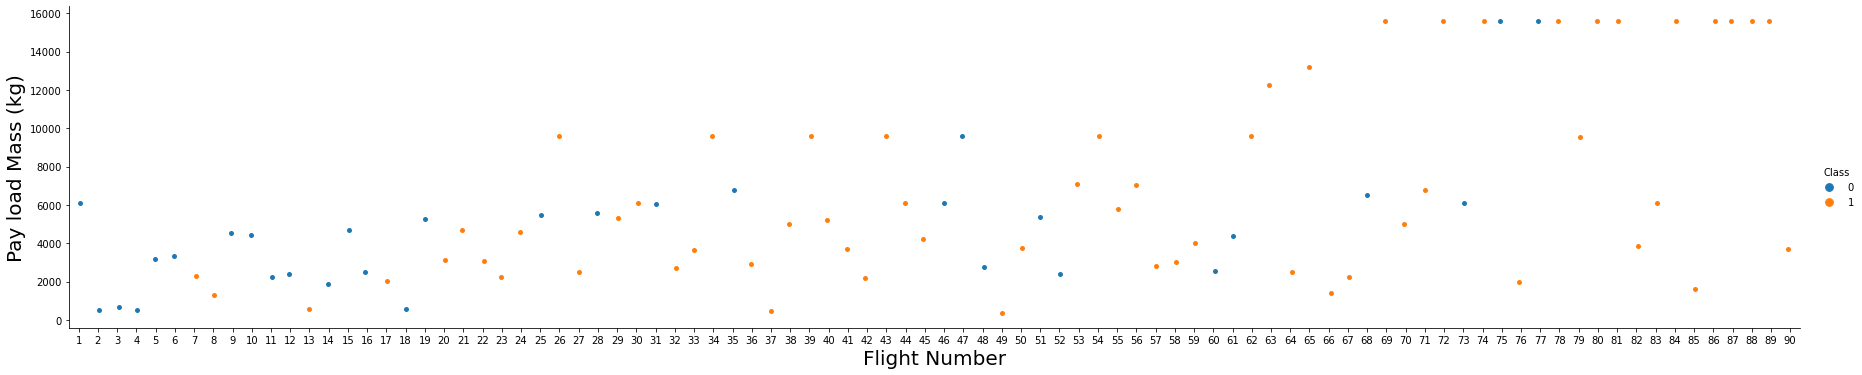

In [63]:
# Plot FlightNumber vs. PayloadMassand
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass is also important; it seems the more massive the payload, the less likely the first stage will return.

Next, let's drill down to each site visualize its detailed launch records.

Visualize the relationship between Flight Number and Launch Site:

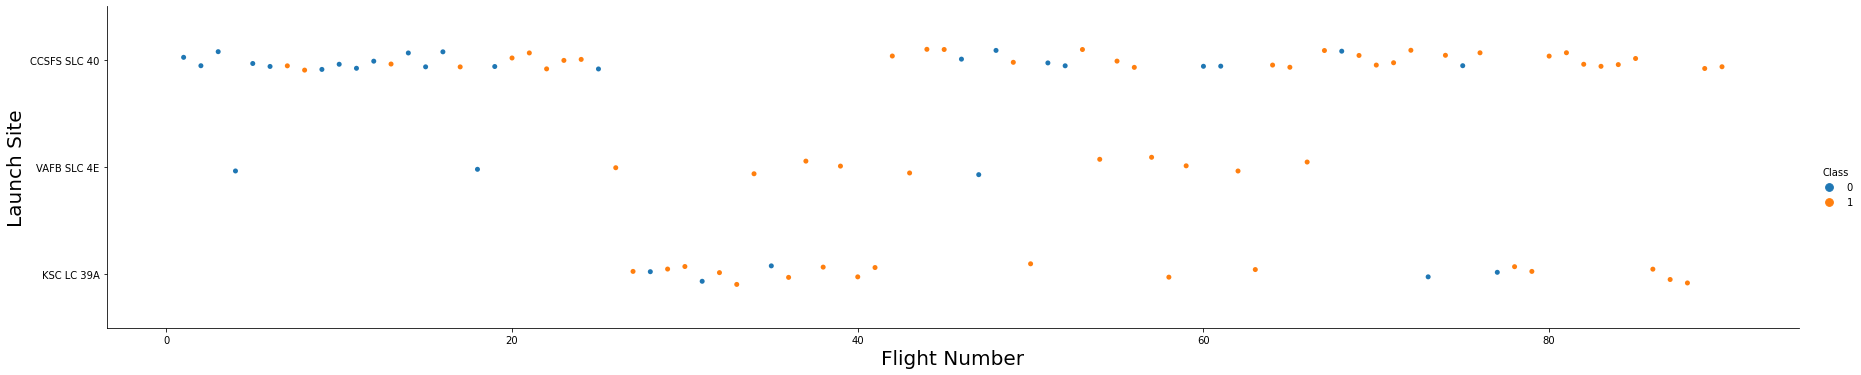

In [64]:
# Plot a scatter point chart with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

* We see that different launch sites have different success rates. `CCAFS LC-40`, has a success rate of 60 %, while `KSC LC-39A` and `VAFB SLC 4E` has a success rate of 77%.
* We see that as the flight number increases, the first stage is more likely to land successfully.

We also want to observe if there is any relationship between launch sites and their payload mass:

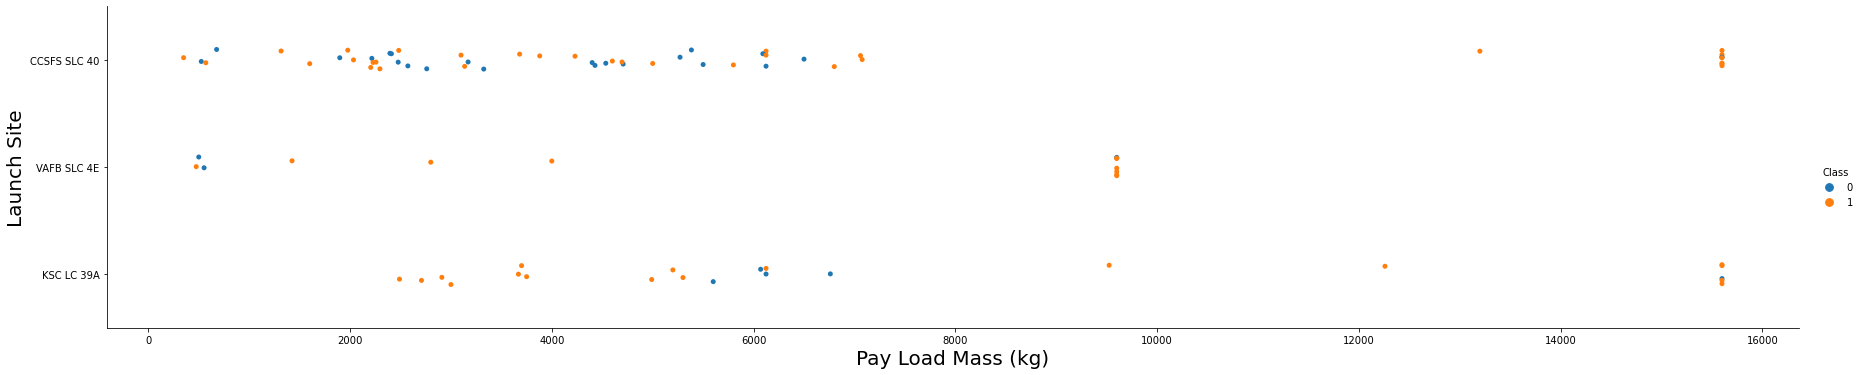

In [65]:
# Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Pay Load Mass (kg)",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

Now if you observe `Payload` Vs. `Launch Site` scatter point chart you will find for the `VAFB-SLC` launchsite there are no rockets launched for heavypayload mass(greater than 10000).

Next, we want to visually check if there are any relationship between success rate and orbit type:

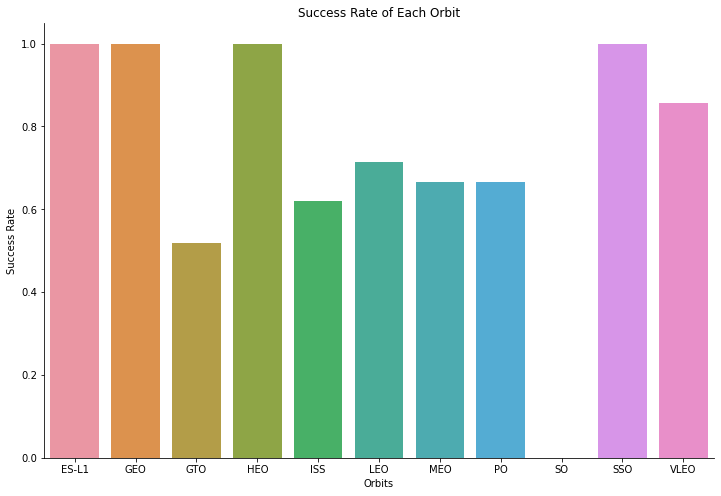

In [66]:
# Use groupby method on Orbit column and get the mean of Class column
bar_data = data_falcon9.groupby("Orbit").mean()['Class'].reset_index()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=bar_data, x="Orbit", y="Class")
ax.set_title("Success Rate of Each Orbit")
ax.set_ylabel("Success Rate")
ax.set_xlabel("Orbits")
sns.despine()
plt.show()

Orbits `ES-L1`, `GEO`, `HEO` and `SSO` has 100% Success Rate. `SO` has never succeded.

For each orbit, we want to see if there is any relationship between `FlightNumber` and `Orbit` type:

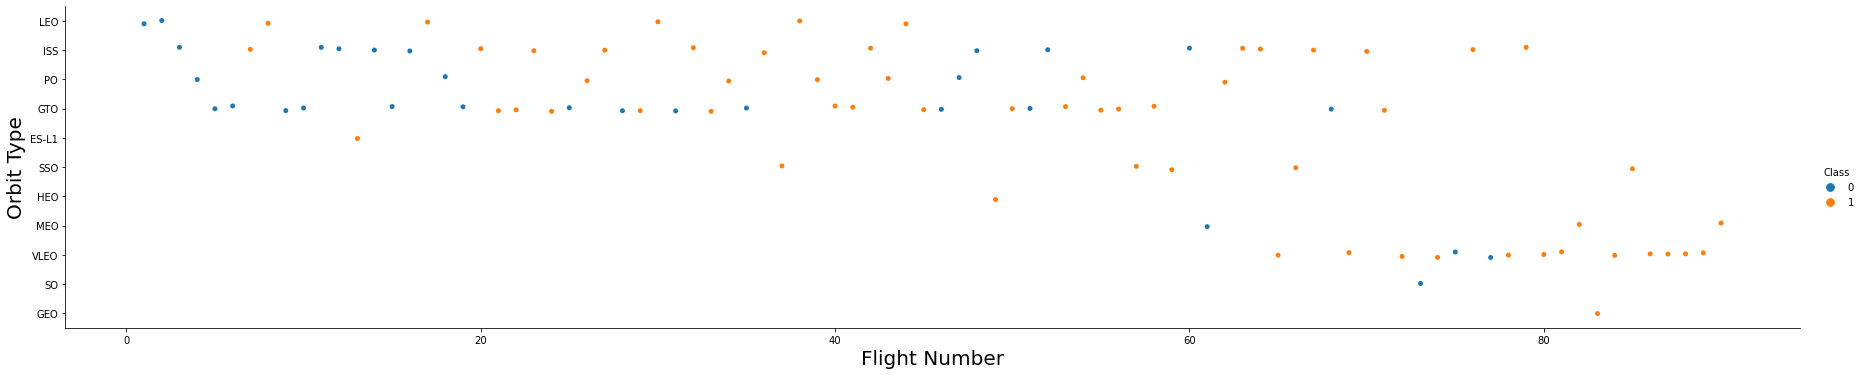

In [67]:
# Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit Type",fontsize=20)
plt.show()

We can see that in the `LEO` orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in `GTO` orbit.

Similarly, we can plot the `Payload` vs. `Orbit` scatter point charts to reveal the relationship between `Payload` and `Orbit` type:

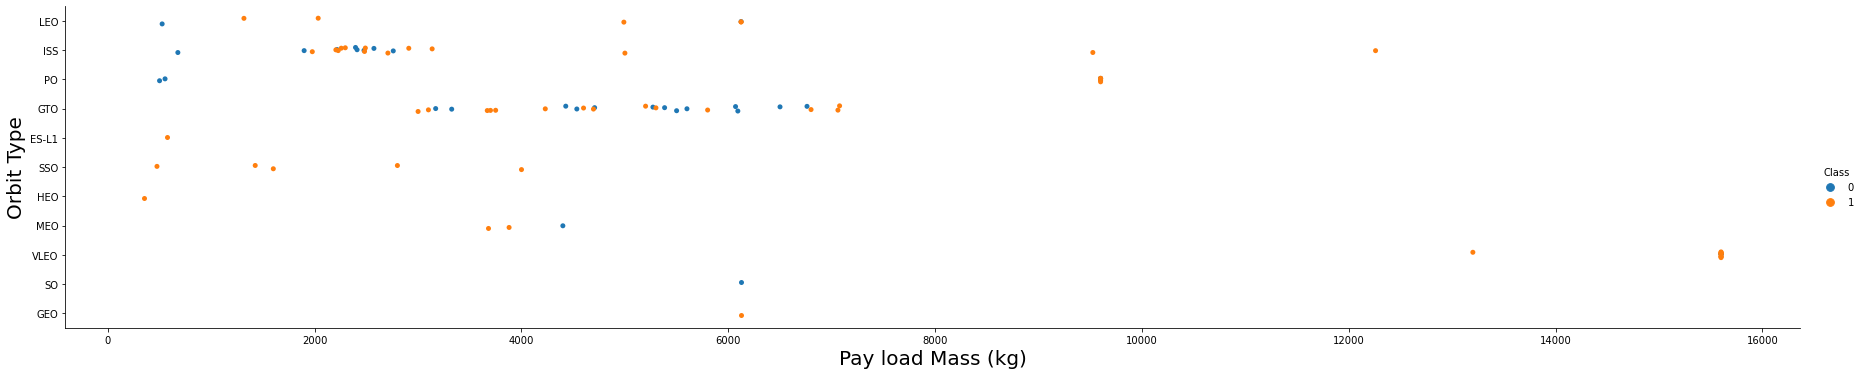

In [68]:
# Plot a scatter point chart with x axis to be Payload and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Pay load Mass (kg)",fontsize=20)
plt.ylabel("Orbit Type",fontsize=20)
plt.show()

With heavy payloads the successful landing or positive landing rate are more for `Polar`, `LEO` and `ISS`.

However for `GTO` we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.

We can plot a line chart with x axis to be `Year` and y axis to be average success rate, to get the average launch success trend. To do this we first need to extract the year from out dataset:

In [69]:
# Empty Year list
year=[]

# A function to Extract years from the date 
def Extract_year(dataset):
    for i in dataset["Date"]:
        year.append(i.year)
    return year

## IF the Date column is not Date Time Type:
#def Extract_year():
#    for i in df["Date"]:
#        year.append(i.split("-")[0])
#    return year

# Execute the function
Extract_year(data_falcon9)

# Change the Date column values to the year list values
data_falcon9['Date'] = year

# Show first 5 rows
data_falcon9.head()

<ipython-input-69-dd26b153c795>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Date'] = year


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


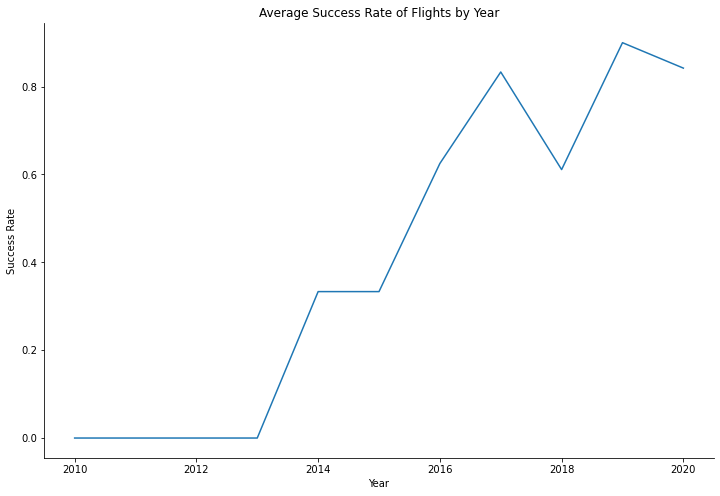

In [70]:
# Plot a line chart with x axis to be the extracted year and y axis to be the success rate
line_data = data_falcon9.groupby('Date')['Class'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=line_data, x="Date", y="Class")
ax.set_title("Average Success Rate of Flights by Year")
ax.set_ylabel("Success Rate")
ax.set_xlabel("Year")
sns.despine()
plt.show()

We can observe that the sucess rate since 2013 kept increasing till 2020.

### Features Engineering

By now, we should obtain some preliminary insights about how each important variable would affect the success rate, we will select the features that will be used in success prediction in the future module.

In [71]:
# Select Features
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]

# Show first 5 rows
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


Let's use the function `get_dummies` and features dataframe to apply `OneHotEncoder` to the column `Orbits`, `LaunchSite`, `LandingPad`, and `Serial`. Then assign the value to the variable `features_one_hot`:

In [72]:
# Use get_dummies
features_one_hot = pd.get_dummies(features, columns= ['Orbit','LaunchSite','LandingPad','Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6123.547647,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,525.000000,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,677.000000,1,False,False,False,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,500.000000,1,False,False,False,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,3170.000000,1,False,False,False,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now that our `features_one_hot` dataframe only contains numbers cast the entire dataframe to variable type `float64`:

In [73]:
# Change all data types to Float64
features_one_hot = features_one_hot.astype(float)

# Show Data Types after the change
features_one_hot.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 80, dtype: object

## Launch Sites Locations Analysis with Folium

The launch success rate may depend on many factors such as payload mass, orbit type, and so on. It may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.

First, let's try to add each site's location on a map using site's latitude and longitude coordinates:

In [74]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = data_falcon9[['LaunchSite', 'Latitude', 'Longitude', 'Class']]
launch_sites_df = spacex_df.groupby(['LaunchSite'], as_index=False).first()
launch_sites_df = launch_sites_df[['LaunchSite', 'Latitude', 'Longitude']]

# Show DataFrame
launch_sites_df

,LaunchSite,Latitude,Longitude
0,CCSFS SLC 40,28.561857,-80.577366
1,KSC LC 39A,28.608058,-80.603956
2,VAFB SLC 4E,34.632093,-120.610829


Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.

We first need to create a folium `Map` object, with an initial center location to be NASA Johnson Space Center at Houston, Texas:

In [75]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We could use `folium.Circle` to add a highlighted circle area with a text label on a specific coordinate. For example:

In [76]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))

# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

Now, let's add a circle for each launch site in DataFrame `launch_sites`:

In [77]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)

# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for index, row in launch_sites_df.iterrows():
    
    coordinate = [row['Latitude'], row['Longitude']]
    
    circle_add = folium.Circle(coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(row['LaunchSite']))
    marker_add = folium.map.Marker(coordinate,icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0),html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % row['LaunchSite'],))
    site_map.add_child(circle_add)
    site_map.add_child(marker_add)

In [78]:
# Show Map
site_map

We can see that all launch sites are near the coast and in military bases: one launch site is in the state of California, specifically inside Vandenberg Space Force Base, and the others are in Florida, specifically inside Cape Canaveral Space Force Station.

Next, let's try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates. Recall that DataFrame `spacex_df` has detailed launch records, and the `Class` column indicates if this launch was successful or not.

In [79]:
# Show DataFrame
spacex_df.head(10)

,LaunchSite,Latitude,Longitude,Class
0,CCSFS SLC 40,28.561857,-80.577366,0
1,CCSFS SLC 40,28.561857,-80.577366,0
2,CCSFS SLC 40,28.561857,-80.577366,0
3,VAFB SLC 4E,34.632093,-120.610829,0
4,CCSFS SLC 40,28.561857,-80.577366,0
5,CCSFS SLC 40,28.561857,-80.577366,0
6,CCSFS SLC 40,28.561857,-80.577366,1
7,CCSFS SLC 40,28.561857,-80.577366,1
8,CCSFS SLC 40,28.561857,-80.577366,0
9,CCSFS SLC 40,28.561857,-80.577366,0


Let's create markers for all launch records. If a launch was successful `(class=1)`, then we use a green marker and if a launch was failed, we use a red marker `(class=0)`:

**Observation**: note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.

In [80]:
# Create a function to assing 'green' to class 1 and 'red' to class 0
def marker_column(row):
    if row == 1:
        return 'green'
    else:
        return 'red'

# Applying the function
spacex_df['marker_color'] = spacex_df['Class'].apply(marker_column)

<ipython-input-80-6eff8968a5be>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spacex_df['marker_color'] = spacex_df['Class'].apply(marker_column)


In [81]:
# Show DataFrame again
spacex_df.head(10)

,LaunchSite,Latitude,Longitude,Class,marker_color
0,CCSFS SLC 40,28.561857,-80.577366,0,red
1,CCSFS SLC 40,28.561857,-80.577366,0,red
2,CCSFS SLC 40,28.561857,-80.577366,0,red
3,VAFB SLC 4E,34.632093,-120.610829,0,red
4,CCSFS SLC 40,28.561857,-80.577366,0,red
5,CCSFS SLC 40,28.561857,-80.577366,0,red
6,CCSFS SLC 40,28.561857,-80.577366,1,green
7,CCSFS SLC 40,28.561857,-80.577366,1,green
8,CCSFS SLC 40,28.561857,-80.577366,0,red
9,CCSFS SLC 40,28.561857,-80.577366,0,red


Now we create a `MarkerCluster` Object and then add a marker to the cluster:

In [82]:
# Let's first create a MarkerCluster object
marker_cluster = MarkerCluster()

In [83]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# For each row in spacex_df data frame create a Marker object with its coordinate and customize the Marker's icon property to indicate if this launch was successed or failed
for index, row in spacex_df.iterrows():
    marker = folium.Marker(location=[row['Latitude'], row['Longitude']],
                           icon=folium.Icon(color='white', icon_color=row['marker_color'],).add_to(site_map))
    marker_cluster.add_child(marker)

# Show Map
site_map

Next, we need to explore and analyze the proximities of launch sites.

Let's first add a `MousePosition` on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, we can easily find the coordinates of any points of interests (such as railway):

In [84]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)

# Show Map
site_map

Note that we can now see the coordinates displayed in the top-right corner of the map when we move the mouse cursor's over the map.

Now let's calculate the distance between launch sites and points of interest:

In [85]:
# Calculate distance between coordinates function
def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

Let's calculate a distance between the launch site KSC LC-39A and the closest city (Titusville):

In [86]:
# First we move the mouse cursor over the city of Titusville and get its coordinate
titusville_coord = [28.58271, -80.81543]
ksc_launch_coord = [28.608058, -80.603956] # KSC LC-39A coordinate

# Execute the distance function
distance_city = calculate_distance(ksc_launch_coord[0], ksc_launch_coord[1], titusville_coord[0], titusville_coord[1]) # [0] Lat, [1] Long

# Show result in KM
distance_city

20.844571839493902

Now we will draw a `PolyLine` between a launch site to the selected city point and create a mark to display the distance result:

In [87]:
# Create a `folium.PolyLine` object using the city coordinates and launch site coordinate
lines=folium.PolyLine(locations=[ksc_launch_coord,titusville_coord], weight=1)
site_map.add_child(lines)

# Create and add a folium.Marker on our selected closest city point on the map and display the distance between the points
distance_marker = folium.Marker(
     titusville_coord, # the mark will be in the city's coordinate
     icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_city),
       )
    )

site_map.add_child(distance_marker)

# Show Map
site_map.add_child(lines)

We can see on the map a line marking the distance between Titusville City and the KSC Launch Site.

Now let's do the same for all launch sites and the closest coast line, city and railway from them:

In [88]:
# First let's find the points of interest for KSC LC-39A Launch Site
ksc_coast_coord = [28.61197, -80.59759]
ksc_railway_coord = [28.60979, -80.59628]
ksc_launch_coord = [28.608058, -80.603956] # KSC LC-39A coordinate

# CCSFS SLC-40 Launch Site points of interest
ccsfs_coast_coord = [28.56219, -80.56781]
ccsfs_city_coord = [28.56342, -80.80856]
ccsfs_railway_coord = [28.57248, -80.58526]
ccsfs_launch_coord = [28.561857, -80.577366] 

# VAFB SLC-4E Launch Site points of interest
vafb_coast_coord = [34.63187, -120.62675]
vafb_city_coord = [34.64211, -120.46114]
vafb_railway_coord = [34.63384, -120.62456]
vafb_launch_coord = [34.632093, -120.610829]

# Assing the points of interest coordinates into a list of points (We will use it for loop)
ksc_points = [ksc_coast_coord, ksc_railway_coord]
ccsfs_points = [ccsfs_coast_coord, ccsfs_city_coord, ccsfs_railway_coord]
vafb_points = [vafb_coast_coord, vafb_city_coord, vafb_railway_coord]

In [89]:
# Let's create a funcion to add the line and the distance marker
def add_line_marker(launchsite_coord, list_points):
    for point_coord in list_points:
        # Calculate distance
        distance = calculate_distance(launchsite_coord[0], launchsite_coord[1], point_coord[0], point_coord[1])
        
        # Create a `folium.PolyLine` object using the point coordinates and launch site coordinate
        lines=folium.PolyLine(locations=[launchsite_coord,point_coord], weight=1)
        site_map.add_child(lines)
        
        # Create and add a folium.Marker on our selected point on the map
        distance_marker = folium.Marker(
                                     point_coord, # the mark will be in the point's coordinate
                                     icon=DivIcon(
                                           icon_size=(20,20),
                                           icon_anchor=(0,0),
                                           html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance),
                                            )
                                        )
        
        site_map.add_child(distance_marker)

In [90]:
# Execute the function to all launch sites
add_line_marker(ksc_launch_coord, ksc_points)
add_line_marker(ccsfs_launch_coord, ccsfs_points)
add_line_marker(vafb_launch_coord, vafb_points)

In [91]:
# Show map
site_map

In the map above we can see that in addition to the launch sites being close to the coast, there are also railway lines nearby. We can see that the launch sites are not to far from cities too.

We can find another points of interest and mark them on the map and try to find new insights, but for now we are good with our findings.

## Build an Interactive Dashboard with Ploty Dash

In this section we will create a Python Script to show interactives dashboards into a HTML page using Ploty Dash. We need a Virtual Enviroment to execute the script like PyCharm or VS Code.

We will use a new CSV file for this section that can be downloaded from the terminal on the Virtual Enviroment.

In [92]:
# Check the dataset
%sql SELECT * FROM SPACEX_LAUNCH_DASH LIMIT 5

 * ibm_db_sa://mtt91672:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/bludb?security=SSL
Done.


flight_number,launch_site,class,payload_mass__kg_,booster_version,booster_version_category
1,CCAFS LC-40,0,0.00,F9 v1.0 B0003,v1.0
2,CCAFS LC-40,0,0.00,F9 v1.0 B0004,v1.0
3,CCAFS LC-40,0,525.00,F9 v1.0 B0005,v1.0
4,CCAFS LC-40,0,500.00,F9 v1.0 B0006,v1.0
5,CCAFS LC-40,0,677.00,F9 v1.0 B0007,v1.0


Here is the python script of our application:

In [ ]:
""" It is just the script, don't run it on this Notebook but from a Virtual Enviroment

## Terminal ##

# Install Packages on terminal
python3.8 -m pip install pandas dash

# Download the dataset to be used in this section
wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv"

## Script ##
# Import required libraries
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.express as px

# Read the airline data into pandas dataframe
spacex_df = pd.read_csv("spacex_launch_dash.csv")
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # Add a dropdown list to enable Launch Site selection and set default selection value to ALL sites
                                dcc.Dropdown(id='site-dropdown',
                                             options=[
                                                    {'label': 'All Sites', 'value': 'ALL'},
                                                    {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                                    {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'},
                                                    {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                                                    {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'}
                                                     ],
                                             value='ALL',
                                             placeholder="Select a Launch Site here",
                                             searchable=True
                                             ),
                                html.Br(),

                                # Add a pie chart to show the total successful launches count for all sites, if a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                # Add a slider to select payload range
                                html.P("Payload range (Kg):"),
                                dcc.RangeSlider(id='payload-slider',
                                                min=0, max=10000, step=100,
                                                marks={0: '0',
                                                       1000: '1000',
                                                       2000: '2000',
                                                       3000: '3000',
                                                       4000: '4000',
                                                       5000: '5000',
                                                       6000: '6000',
                                                       7000: '7000',
                                                       8000: '8000',
                                                       9000: '9000',
                                                       10000: '10000'},
                                                value=[min_payload, max_payload]),

                                # Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))

# Function decorator to specify function input and output
def get_pie_chart(entered_site):
    filtered_df = spacex_df   

    if entered_site == 'ALL':
        
        fig = px.pie(filtered_df, values='class', 
        names='Launch Site', 
        title='Success Counts by Launch Site')
        return fig
    
    else: 
        launch_site = filtered_df[filtered_df['Launch Site'] == entered_site]
        launch_site = launch_site.groupby(['Launch Site','class']).size().reset_index(name='class count')
        fig = px.pie(launch_site, values="class count", names='class', title=f"Success Counts {entered_site}")
        return fig

# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(Output(component_id='success-payload-scatter-chart', component_property='figure'),
              [Input(component_id='site-dropdown', component_property='value'), 
              Input(component_id="payload-slider", component_property="value")])

# Function decorator to specify function input and output
def get_scatter_plot(entered_site,entered_payload):
    filtered_df = spacex_df
    if entered_site == 'ALL':
        payload_outcome = filtered_df[(filtered_df['Payload Mass (kg)'] >= entered_payload[0]) & (filtered_df['Payload Mass (kg)'] <= entered_payload[1])]
        fig = px.scatter(payload_outcome, x="Payload Mass (kg)", y="class", color="Booster Version Category", symbol="Booster Version Category",
        title='Correlation between Payload Mass vs all Launch Sites')
        return fig
    else:
        payload_outcome = filtered_df[(filtered_df['Launch Site'] == entered_site) & (filtered_df['Payload Mass (kg)'] >= entered_payload[0]) & (filtered_df['Payload Mass (kg)'] <= entered_payload[1])]
        fig = px.scatter(payload_outcome, x="Payload Mass (kg)", y="class", color="Booster Version Category", symbol="Booster Version Category",
        title=f"Correlation between Payload Mass vs {entered_site} Site")
        return fig

# Run the app
if __name__ == '__main__':
    app.run_server()

We can see the results of our applications here:

<center><img alt="SpaceX Launch Records Dashboard" src='https://github.com/octavianosilva/Imagens_projetos/blob/main/SpaceX%20Launch%20Records%20Dashboard.png?raw=true'></center>

With our new Dashboard application, we can get some insights:

* The Launch Site KSC LC-39A has the largest successful launches (41.7%);

* The Launch Site KSC LC-39A has the highest launch success rate (76.9%);

* The Payload Mass (Kg) Range between 3k and 3.7k Kg has the highest launch success rate;

* The Payload Mass (Kg) Range between 500 and 677 Kg has the lowest launch success rate;

* The Booster Version FT has the highest launch success rate.

## Machine Learning Prediction

Now it is time to predict if the Falcon 9 first stage will land successfully.

We will test the following classification algorithms and choose the best one for our problem: 

* Logistic Regression;

* Support Vector Machine;

* Decision Tree; and,

* K Nearest Neighbors.

First let's see our datasets that will be used for modeling:

In [95]:
# data_falcon9
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [97]:
# Features dataset
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# Check the number of entries for each dataset
print('data_falcon9 has {} entries.'.format(data_falcon9.shape[0]))
print('features_one_hot has {} entries.'.format(features_one_hot.shape[0]))

data_falcon9 has 90 entries.
features_one_hot has 90 entries.


We already selected our features when we created the `features_one_hot` from `data_falcon9` dataset in a previous section, but we don't selected our target information that time, so that is why the features dataset don't have a `Class` column.

Let´s create a `NumPy array` from the column `Class` in `data_falcon9`, by applying the method `to_numpy()` then assign it to the variable `Y`:

In [102]:
# Assing our target variable from data_falcon9 dataset to a variable Y
Y = data_falcon9['Class'].to_numpy()

Now we need to standardize our features from `features_one_hot` dataset and then reassign it to a variable `features_std`:

In [103]:
# Create a StandardScaler instance
transform = preprocessing.StandardScaler()

# Apply the transformer and assing the results to a new variable
features_std = transform.fit(features_one_hot).transform(features_one_hot)

We split the data into training and testing data using the function `train_test_split`. The training data is divided into validation data, a second set used for training data; then the models are trained and hyperparameters are selected using the function `GridSearchCV`, we will use the metric `accuracy` to evaluate our models:

In [105]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_std, Y, test_size=0.2, random_state=2)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (72, 80) (72,)
Test set: (18, 80) (18,)


Now it is time to train our models.

### Logistic Regression

First we create our parameters dictionary for `GridSearchCV`:

In [108]:
# Parameters for GridSearch
parameters_lr = {'C':[0.01,0.1,1],
                 'penalty':['l2'],
                 'solver':['lbfgs']
                }

We need to create our model instance first and then we train it:

In [109]:
# Create our Logistic Regression instance
lr=LogisticRegression()

# Create the Grid Search instance
logreg_cv = GridSearchCV(lr, parameters_lr, scoring='accuracy', n_jobs=-1, cv=10)

# Train the model with the Grid Search
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy')

We output the `GridSearchCV` object for Logistic Regression. We display the best parameters using the data attribute `best_params_` and the accuracy on the validation data using the data attribute `best_score_`:

In [124]:
# Show the model hyperparameters
print("Tuned Hyperparameters:",logreg_cv.best_params_)

# Show Accuracy score
print("Accuracy :",logreg_cv.best_score_)

Tuned Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8214285714285714


Let's calculate the accuracy on the test data using the method `score`:

In [112]:
# Calculate the accuracy on the test data
logreg_cv.score(X_test, y_test)

0.8333333333333334

Now we can see the classification report and the confusion matrix of the model:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



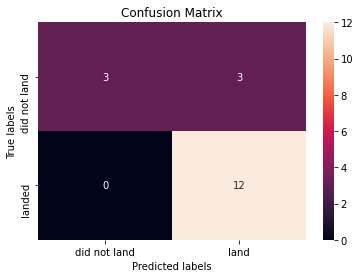

In [115]:
# Predict the test labels
yhat=logreg_cv.predict(X_test)

# Classification Report
print(classification_report(y_test, yhat))

# Create a Confusion Matrix Function
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

# Confusion Matrix
plot_confusion_matrix(y_test,yhat)

Examining the classification report and confusion matrix, we see that Logistic Regression can distinguish between the different classes. We see that the major problem is False Positives.

Now let's compare the results of other models and then select the best one for our problem.

### Support Vector Machine

Parameters dictionary for `GridSearchCV`:

In [117]:
# Parameters for GridSearch
parameters_svm = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
                  'C': np.logspace(-3, 3, 5),
                  'gamma':np.logspace(-3, 3, 5)
                 }

# Create our Support Vector Machine instance
svm = SVC()

In [118]:
# Create the Grid Search instance
svm_cv = GridSearchCV(svm, parameters_svm, scoring='accuracy', n_jobs=-1, cv=10)

# Train the model with the Grid Search
svm_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy')

In [125]:
# Show the model hyperparameters
print("Tuned Hyperparameters:",svm_cv.best_params_)

# Show Accuracy score
print("Accuracy :",svm_cv.best_score_)

Tuned Hyperparameters: {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy : 0.8482142857142858


Calcule the Test accuracy:

In [120]:
# Calculate the accuracy on the test data
svm_cv.score(X_test, y_test)

0.8333333333333334

Show the classification report and the confusion matrix:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



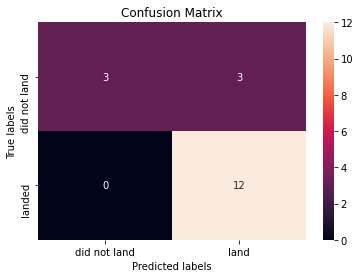

In [121]:
# Predict the test labels
yhat_svm = svm_cv.predict(X_test)

# Classification Report
print(classification_report(y_test, yhat_svm))

# Confusion Matrix
plot_confusion_matrix(y_test,yhat_svm)

### Decision Tree

Parameters for `GridSearchCV`:

In [127]:
# Parameters for GridSearch
parameters_tree = {'criterion': ['gini', 'entropy'],
                   'splitter': ['best', 'random'],
                   'max_depth': [2*n for n in range(1,10)],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10]
                  }

# Create our Decision Tree instance
tree = DecisionTreeClassifier()

In [128]:
# Create the Grid Search instance
tree_cv = GridSearchCV(tree, parameters_tree, scoring='accuracy', n_jobs=-1, cv=10)

# Train the model with the Grid Search
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [129]:
# Show the model hyperparameters
print("Tuned Hyperparameters:",tree_cv.best_params_)

# Show Accuracy score
print("Accuracy :",tree_cv.best_score_)

Tuned Hyperparameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
Accuracy : 0.9017857142857142


Calculate the accuracy for Test data:

In [130]:
# Calculate the accuracy on the test data
tree_cv.score(X_test, y_test)

0.7222222222222222

Show the classification report and the confusion matrix:

              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.77      0.83      0.80        12

    accuracy                           0.72        18
   macro avg       0.68      0.67      0.67        18
weighted avg       0.71      0.72      0.72        18



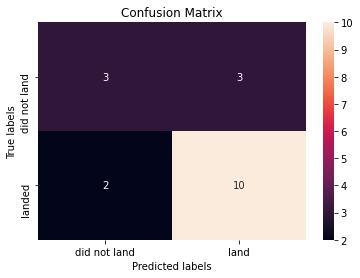

In [131]:
# Predict the test labels
yhat_tree = tree_cv.predict(X_test)

# Classification Report
print(classification_report(y_test, yhat_tree))

# Confusion Matrix
plot_confusion_matrix(y_test,yhat_tree)

### K-Nearest Neighbors

Parameters for `GridSearchCV`:

In [132]:
# Parameters for GridSearch
parameters_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'p': [1,2]
                 }

# Create our K-Nearest Neighbors instance
KNN = KNeighborsClassifier()

In [133]:
# Create the Grid Search instance
KNN_cv = GridSearchCV(KNN, parameters_knn, scoring='accuracy', n_jobs=-1, cv=10)

# Train the model with the Grid Search
KNN_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             scoring='accuracy')

In [134]:
# Show the model hyperparameters
print("Tuned Hyperparameters:",KNN_cv.best_params_)

# Show Accuracy score
print("Accuracy :",KNN_cv.best_score_)

Tuned Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
Accuracy : 0.8339285714285714


Calculate the accuracy for Test data:

In [135]:
# Calculate the accuracy on the test data
KNN_cv.score(X_test, y_test)

0.7777777777777778

Show the classification report and the confusion matrix:

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.75      1.00      0.86        12

    accuracy                           0.78        18
   macro avg       0.88      0.67      0.68        18
weighted avg       0.83      0.78      0.74        18



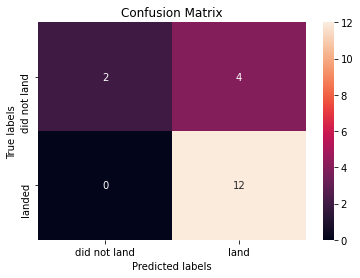

In [136]:
# Predict the test labels
yhat_KNN = KNN_cv.predict(X_test)

# Classification Report
print(classification_report(y_test, yhat_KNN))

# Confusion Matrix
plot_confusion_matrix(y_test,yhat_KNN)

Let's create a bar chart with all models accuracy:

In [1]:
# Create a DataFrame
models_df = {'Model':['LR','SVM','DT','KNN'],
             'Accuracy': [0.83,0.83,0.72,0.77]}

models_df = pd.DataFrame(models_df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

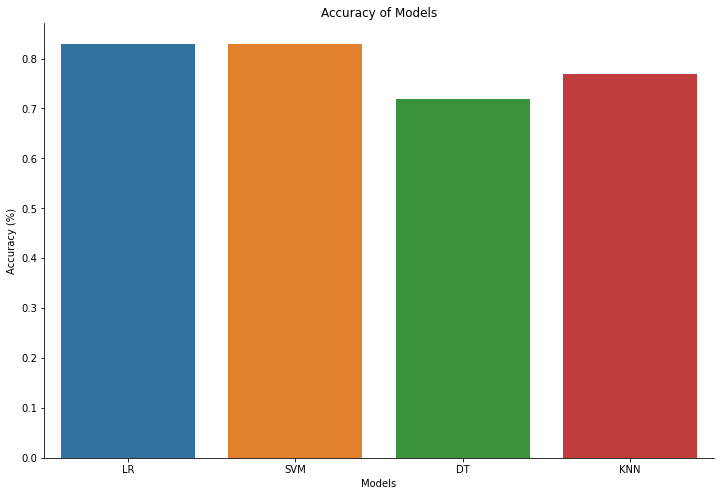

In [3]:
# Plot bar graph
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=models_df, x="Model", y="Accuracy")
ax.set_title("Accuracy of Models")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Models")
sns.despine()
plt.show()

### Results

We have two models that performed better, but they have exactly the same results for the test data: Accuracy, Precision, Recall and F1-Score, and they are Logistic Regression and Support Vector Machine.

"*When evaluating machine learning models, if the accuracy, confusion matrix, precision, recall, and F1 score are identical, it indicates that the models perform similarly in terms of overall predictive performance. In such cases, you are correct that other factors should be considered to determine the best model for your specific requirements. Here are some suggestions and guidance to help you make an informed decision:*

1. ***Interpretability**: If interpretability is a priority for your problem, Logistic Regression can be a suitable choice. It provides coefficients that represent the impact of features on the predicted outcome, allowing for easy interpretation and understanding of the model's behavior.*

2. ***Training and Prediction Speed**: Logistic Regression and Decision Tree Classifiers are generally faster to train and predict compared to models like SVM and K-nearest Neighbors. If efficiency is important, these models can be preferred, especially if there is no evidence suggesting that a more complex model is necessary.*

3. ***Decision Boundary Complexity**: If you suspect that the relationship between features and the outcome of the landing may be non-linear, models like SVM or Decision Trees can capture non-linear patterns better than Logistic Regression. By considering the nature of the relationship, you can choose the appropriate model. If linearity is more appropriate, Logistic Regression might be favored.*

4. ***Model Complexity and Overfitting**: Consider the complexity of the models and the risk of overfitting. More complex models with intricate decision boundaries, such as SVM with non-linear kernels or ensemble methods like Random Forest, have the potential to capture complex relationships but can be prone to overfitting if the data is limited. If you have a smaller dataset, it is generally recommended to avoid overly complex models.*

5. ***Cross-Validation and Performance Stability**: While the overall performance metrics might be similar, it is worth performing cross-validation or evaluating the stability of the models' performance. Models with lower variance in their performance across different folds or subsets of the data could be preferred, as they indicate more stable and reliable predictions.*

*Ultimately, the choice of the model depends on a combination of factors, including accuracy, interpretability, efficiency, complexity, and the characteristics of your specific problem. It can be helpful to experiment with different models, assess their performance, and consider the trade-offs between various factors before making a final decision.*"

The above explanation is taken from a comment by Coursera staff member Anita Verma, which I found helpful in explaining the results obtained with our two selected models.